# Detecting Faulty Water Pumps

## Problem Statement

"Pump It Up: Data Mining the Water Table" is one of the current active competitions on DrivenData. Using data aggregated from the Tanzania Ministry of Water, participants can build models to predict the status of a waterpoint: `functional`, `functional needs repair`, or `non functional`. The dataset includes geographical, structural and administrative information. 

Our task is to analyse the data and find the best model that can predict the operating condition of a waterpoint for each record in the dataset with the highest accuracy possible.

In [22]:
# Surpress warnings
options(warn=-1)

# Import libraries
library(dplyr)
library(ggplot2)
library(lubridate)
library(ipred)
library(randomForest)
library(gbm)
library(caret)
library(e1071)
library(kernlab)

In [2]:
# Set seed
set.seed(1234)

In [3]:
# Read both training and test datasets
train_x = read.csv('train-x.csv', header = TRUE, stringsAsFactors = FALSE)
train_y = read.csv('train-y.csv', header = TRUE, stringsAsFactors = FALSE)
test_x = read.csv('test-x.csv', header = TRUE, stringsAsFactors = FALSE)

# Merge training data frames to create a single training data frame
train = merge(train_y, train_x)

## Data Exploration & Preparation

There are 39 independent variables that can be potentially powerful variables in terms of prediction.  Before we start building the model, we first explore the data so we can decide whether any variables should be dropped from model building due to redundancy or irrelevancy, develop any strategies required for imputing missing data values, and also decide whether any of the predictor variables may need to be mathematically transformed to better serve the model building process. 

The plot below shows the number of pumps for each pump’s status value based on the training dataset. 

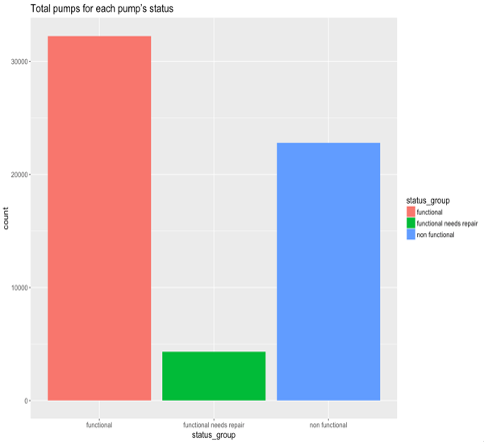

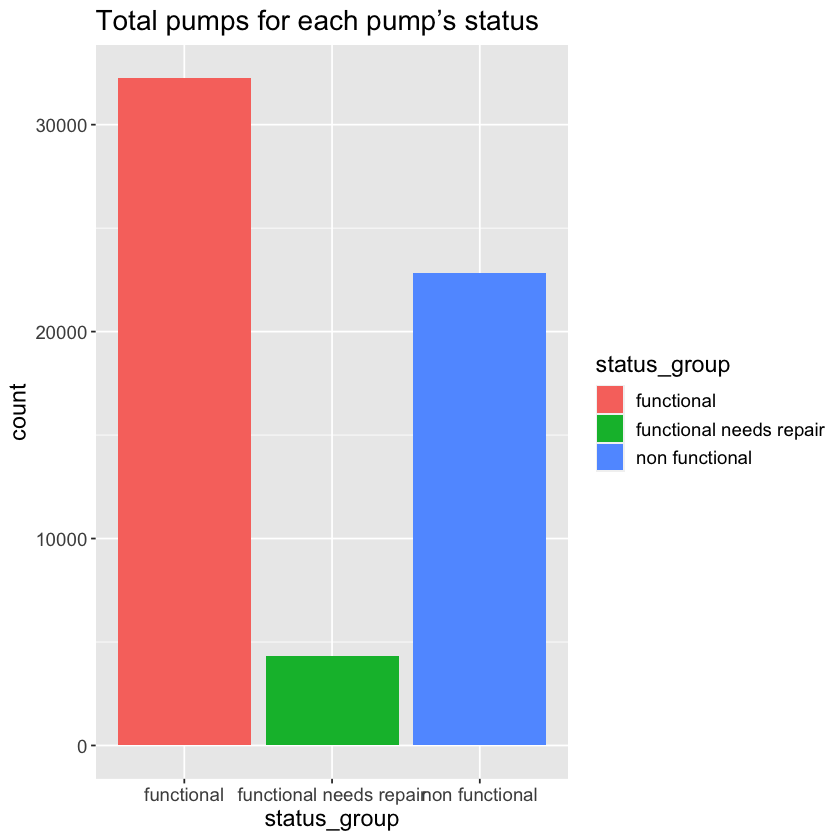

In [4]:
# Count number of pumps for each pump’s status value
ggplot(train, aes(status_group)) + geom_bar(aes(fill = status_group)) + ggtitle(label = "Total pumps for each pump’s status") + theme(text = element_text(size = 14))

In [5]:
# Look at the distrubution of water pump statuses in training dataset
table(train$status_group)
prop.table(table(train$status_group))


             functional functional needs repair          non functional 
                  32259                    4317                   22824 


             functional functional needs repair          non functional 
             0.54308081              0.07267677              0.38424242 

In terms of percentages:
- 54.3% of all pumps are functional
- 38.4% of all pumps are non functional
- 7.3% of all pumps are functional needs repair

When we analyse the data for missing values, we can see that there are significant number of missing values for both numerical and categorical variables. 31,587 observations of the 59,400 records have at least one missing value (53.17%).

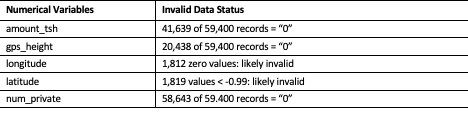
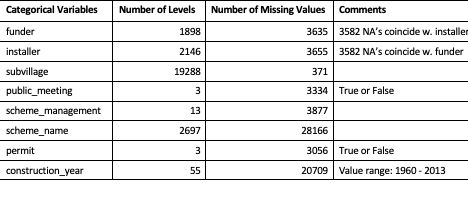

In [6]:
# Check for missing values
## Numeric Variables
length(which(train$amount_tsh == 0))
length(which(train$gps_height == 0))
length(which(train$population == 0))
length(which(train$longitude == 0))
length(which(train$latitude > -1))
length(which(train$construction_year == 0))

## Categorical variables
for (i in colnames(train)) {
  missing = length(which(train[,i] %in% c("", NA, NaN)))
  if(missing > 0) {
    cat(i, ":", missing, "  ")
  }
}

# Check which variables are factor or string
names(Filter(is.factor, train))
names(Filter(is.character, train))

[1] 41639

[1] 20438

[1] 21381

[1] 1812

[1] 1819

[1] 20709

funder : 3635   installer : 3655   subvillage : 371   public_meeting : 3334   scheme_management : 3877   scheme_name : 28166   permit : 3056   

character(0)

[1] "status_group"          "date_recorded"         "funder"               
 [4] "installer"             "wpt_name"              "basin"                
 [7] "subvillage"            "region"                "lga"                  
[10] "ward"                  "public_meeting"        "recorded_by"          
[13] "scheme_management"     "scheme_name"           "permit"               
[16] "extraction_type"       "extraction_type_group" "extraction_type_class"
[19] "management"            "management_group"      "payment"              
[22] "payment_type"          "water_quality"         "quality_group"        
[25] "quantity"              "quantity_group"        "source"               
[28] "source_type"           "source_class"          "waterpoint_type"      
[31] "waterpoint_type_group"

After the data exploration procedure is completed, we can now manipulate and prepare the dataset so we can finally build our prediction models. First, we drop all the variables that are likely offers limited value in terms of prediction.

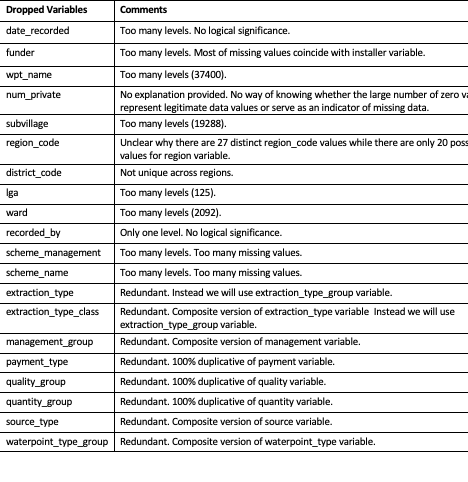

In [7]:
# Remove redundant and irrelevant variables from datasets
## List all the variables that are no good for predictive modeling
rm_features = c("date_recorded", "funder", "wpt_name", "num_private", "subvillage", "region_code", "district_code", "lga", 
                "ward", "recorded_by", "scheme_name", "scheme_management", "extraction_type", "extraction_type_class", "management_group",
                "payment_type", "quality_group", "quantity_group", "source_type", "waterpoint_type_group")
## Number of redundant and irrelevant variables to be removed
length(rm_features)
## Remove 18 variables from both training and test datasets
train = train[,!(names(train) %in% rm_features)]
dim(train)
test_x = test_x[,!(names(test_x) %in% rm_features)]
dim(test_x)

[1] 20

[1] 59400    21

[1] 14850    20

Next, we impute missing values for all the significant independent variables to be used for predictive modeling purposes. Our strategies for imputing missing/invalid data values are summarized for each variable used in our models below.

### amount_tsh

This variable can be characterized as representing metrics indicating total static head for pump. The `extraction_type_group` variable might be considered as indicative of the type of pump deployed at each waterpoint. 

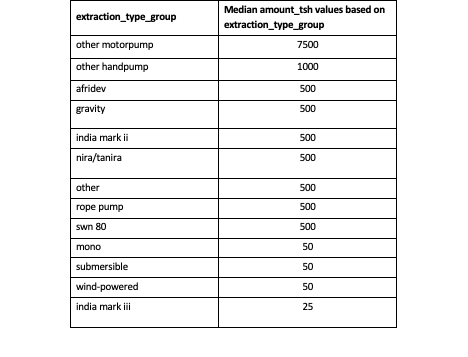
Since each pump represented within the dataset has known values for `extraction_type_group` variable, we impute missing (zero) `amount_tsh` values with medians of amount_tsh values by `extraction_type_group`.

In [8]:
# AMOUNT_TSH variable (Imputation)
## Create a subset of non-zero gps_height records
atshTrain = subset(train, amount_tsh > 0)
atshTest = subset(test_x, amount_tsh > 0)
## Create a subset of zero gps_height records
atshzTrain = subset(train, amount_tsh == 0)
atshzTest = subset(test_x, amount_tsh == 0)
## Summary amount_tsh values by extraction_type_group
arrange(summarise(group_by(atshTrain, extraction_type_group), MedTsh = median(amount_tsh) ), desc(MedTsh) )
## Check median amount_tsh values by extraction_type_group
median.atshTrain = arrange(summarise(group_by(atshTrain, extraction_type_group), median(amount_tsh)))
median.atshTest = arrange(summarise(group_by(atshTest, extraction_type_group), median(amount_tsh)))
## Impute zero amount_tsh values with the median of non-zero amount_tsh values by extraction_type_group
for (i in 1:nrow(atshzTrain)) {
  # assign extraction_type median value
  atshzTrain$amount_tsh[i] = median.atshTrain$`median(amount_tsh)`[median.atshTrain$extraction_type_group == atshzTrain$extraction_type_group[i]]
}
for (i in 1:nrow(atshzTest)) {
  # assign extraction_type median value
  atshzTest$amount_tsh[i] = median.atshTest$`median(amount_tsh)`[median.atshTest$extraction_type_group == atshzTest$extraction_type_group[i]]
}
# Put imputed values into both training and test datasets
train$amount_tsh[train$amount_tsh == 0] = atshzTrain$amount_tsh
test_x$amount_tsh[test_x$amount_tsh == 0] = atshzTest$amount_tsh

extraction_type_group,MedTsh
<chr>,<dbl>
other motorpump,7500
other handpump,1000
afridev,500
gravity,500
india mark ii,500
nira/tanira,500
other,500
rope pump,500
swn 80,500


### installer

When examining the installer variable, we can see that there are a lot of terms that are likely the same installer, but have different names. For example, there are many instances that refer to 'Government': 'Gover', 'GOVER', 'Government', 'Govt' etc. All of these can be considered different factors unless we find a way to aggregate them. As a solution, we can take the first 3 letters of each factor and make them lower case. Then, we can aggregate the terms that are most frequent and only use those as predictors, putting all other variables into an 'other' category. The new variable created is called “install_3” and we will use it for predictive modelling instead of installer variable.

In [9]:
# INSTALLER variable (Imputation)
train$installer = as.factor(train$installer)
summary(train$installer)
test_x$installer = as.factor(test_x$installer)
summary(test_x$installer)
### Make installer lowercase and take first 3 letters as a sub string
train$install_3 = substr(tolower(train$installer),1,3)
train$install_3[train$install_3 %in% c(" ", "", "0", "_", "-")] = "other"
### Take the top 15 substrings by occurance frequency
install_top_15 = names(summary(as.factor(train$install_3)))[1:15]
train$install_3[!(train$install_3 %in% install_top_15)] = "other"
train$install_3 = as.factor(train$install_3)
### Remove installer variable from training dataset
train = train[,!(names(train) == "installer")]
### Create install_3 for test dataset using same top 15 from above
test_x$install_3 = substr(tolower(test_x$installer),1,3)
test_x$install_3[test_x$install_3 %in% c(" ", "", "0", "_", "-")] = "other"
test_x$install_3[!(test_x$install_3 %in% install_top_15)] = "other"
test_x$install_3 = as.factor(test_x$install_3)
### Remove installer variable from test dataset
test_x = test_x[,!(names(test_x) == "installer")]

DWE                               
                        17402                          3655 
                   Government                           RWE 
                         1825                          1206 
                        Commu                        DANIDA 
                         1060                          1050 
                         KKKT                        Hesawa 
                          898                           840 
                            0                          TCRS 
                          777                           707 
           Central government                           CES 
                          622                           610 
                    Community                         DANID 
                          553                           552 
             District Council                        HESAWA 
                          551                           539 
                          LGA                  World vision 
                          408                           408 
                       WEDECO                         TASAF 
                          397                           396 
             District council                         Gover 
                          392                           383 
                        AMREF                         TWESA 
                          329                           316 
                           WU                          Dmdd 
                          301                           287 
                         ACRA                  World Vision 
                          278                           270 
                         SEMA                            DW 
                          249                           246 
                        OXFAM                            Da 
                          234                           224 
                         Gove                 Idara ya maji 
                          222                           222 
                       UNICEF    Sengerema Water Department 
                          222                           214 
                    Kiliwater                          FinW 
                          210                           208 
                        NORAD                            DH 
                          208                           202 
                    Villagers                          DWSP 
                          199                           192 
                       Distri          Lawatefuka water sup 
                          181                           180 
         Magadini-Makiwaru wa                            RC 
                          175                           174 
                           FW          KKKT _ Konde and DWE 
                          173                           166 
                        Centr                           WVT 
                          162                           158 
                          MWE           Handeni Trunk Main( 
                          157                           156 
                           Is                         Norad 
                          154                           152 
                   Fini Water                         RWSSP 
                          149                           149 
                        SHIPO                       Private 
                          147                           143 
                       Kuwait                         JAICA 
                          142                           141 
                 Central govt                       Artisan 
                          138                           135 
                          ISF                    Fini water 
                          135                           133 
                        GOVER                          DDCA 
                          128                           126 


DWE                               
                         4349                           877 
                   Government                           RWE 
                          457                           292 
                        Commu                        DANIDA 
                          287                           255 
                       Hesawa                          KKKT 
                          230                           222 
                            0                          TCRS 
                          203                           180 
                          CES            Central government 
                          155                           142 
                       HESAWA                         DANID 
                          140                           138 
                    Community              District Council 
                          134                           112 
                 World vision                         TASAF 
                          109                           108 
                        Gover                        WEDECO 
                          100                            99 
             District council                           LGA 
                           98                            93 
                        TWESA                            WU 
                           79                            76 
                        AMREF                          Dmdd 
                           69                            69 
                         ACRA                            Da 
                           68                            63 
                       UNICEF                     Villagers 
                           63                            63 
                           DW                          SEMA 
                           62                            62 
                    Kiliwater                          FinW 
                           61                            59 
                 World Vision                          Gove 
                           56                            54 
                        OXFAM           Handeni Trunk Main( 
                           54                            52 
                        NORAD          Magadini-Makiwaru wa 
                           52                            51 
         Lawatefuka water sup                           WVT 
                           49                            48 
                         DWSP                       Mission 
                           47                            46 
                       Kuwait                            RC 
                           45                            45 
                           DH    Sengerema Water Department 
                           44                            44 
                       Distri                         JAICA 
                           43                            43 
         KKKT _ Konde and DWE                         GOVER 
                           43                            42 
                           FW                           MWE 
                           41                            41 
                      Private                    Fini Water 
                           40                            39 
                        Norad                  Central govt 
                           38                            37 
                    RC CHURCH                         SHIPO 
                           37                            36 
                      Artisan                         Centr 
                           34                            33 
                          ISF                            Is 
                           33                            33 
                Idara ya maji                         World 
                           32                            32 


### longitude and latitude

According to the WorldAtlas , the minimum and maximum longitude values for Tanzania are respectively 29.33 and 40.45; and the minimum and maximum latitude values for Tanzania are respectively -11.75 and -0.99. Based on these references, we should update all the values that are out of these ranges, for both longitude and latitude variables:
- Impute invalid (out-of-range) longitude values with the mean of legitimate longitude values. 
- Impute invalid (out-of-range) latitude values with the mean of legitimate latitude values.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   33.09   34.91   34.08   37.18   40.35 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   33.07   34.90   34.06   37.20   40.33 

[1] 1812

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  29.61   33.29   35.01   35.15   37.23   40.35 

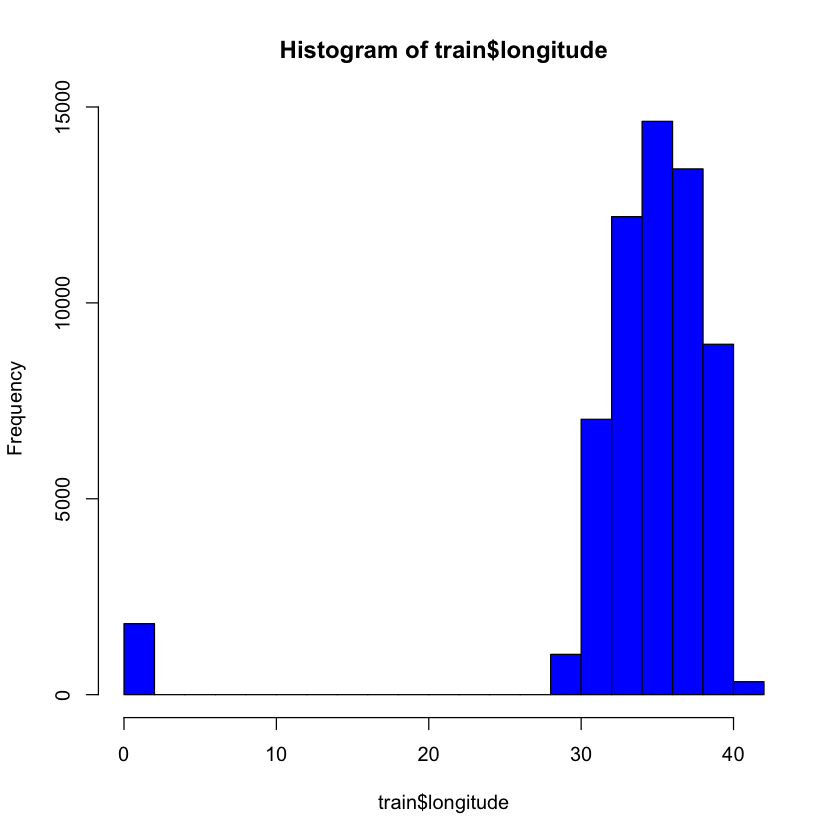

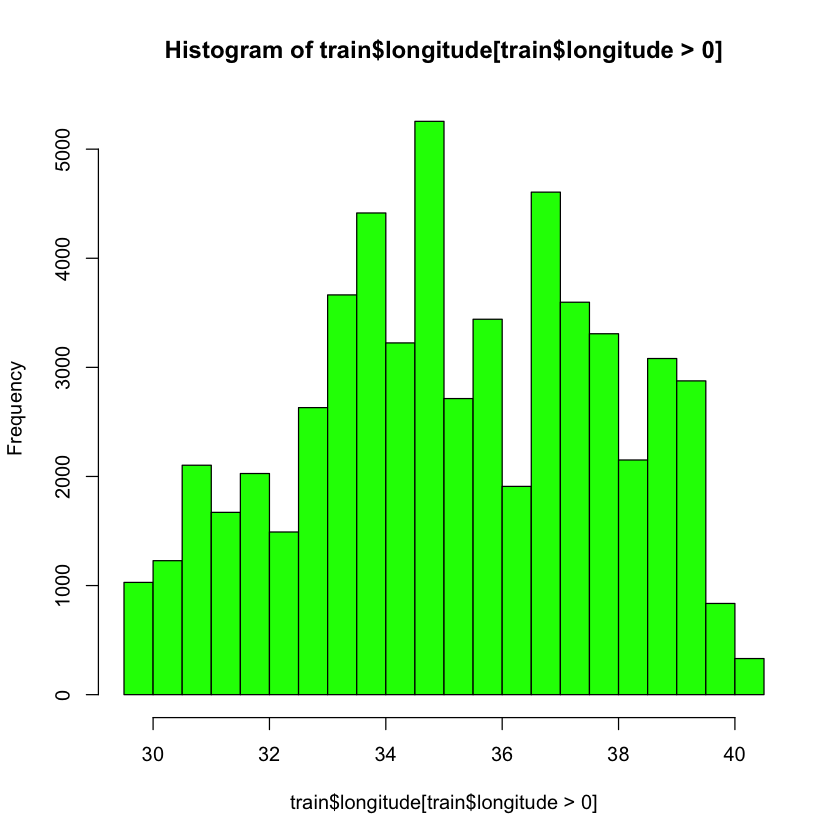

In [10]:
# LONGITUDE variable (Imputation)
summary(train$longitude)
summary(test_x$longitude)
hist(train$longitude, col = "blue")
length(which(train$longitude == 0))
summary(train$longitude[train$longitude > 0])
hist(train$longitude[train$longitude > 0], col = "green")
## Calculate the mean of longitude for each region and use those values 
## as the imputed values for the missing data of TRAINING data set
for(i in unique(train$region)) {
  if(length(train$longitude[which(train$longitude == 0 & train$region == i)]) > 0) {
    train$longitude[which(train$longitude == 0 & train$region == i)] = mean(train$longitude[which(train$region==i & train$longitude>0)])
  }
}
## Calculate the mean of longitude for each region and use those values 
## as the imputed values for the missing data of TEST data set
for(i in unique(test_x$region)) {
  if(length(test_x$longitude[which(test_x$longitude == 0 & test_x$region == i)]) > 0) {
    test_x$longitude[which(test_x$longitude == 0 & test_x$region == i)] = mean(test_x$longitude[which(test_x$region==i & test_x$longitude>0)])
  }
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-11.649  -8.541  -5.022  -5.706  -3.326   0.000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-11.565  -8.444  -5.050  -5.685  -3.321   0.000 

[1] 0

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
                                                

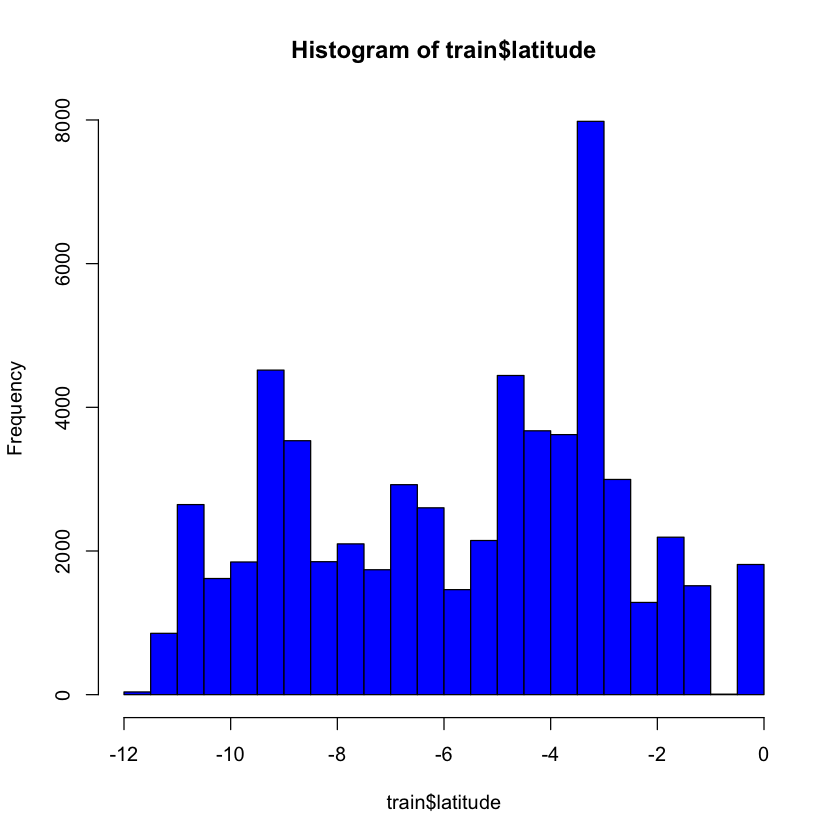

[1] 0

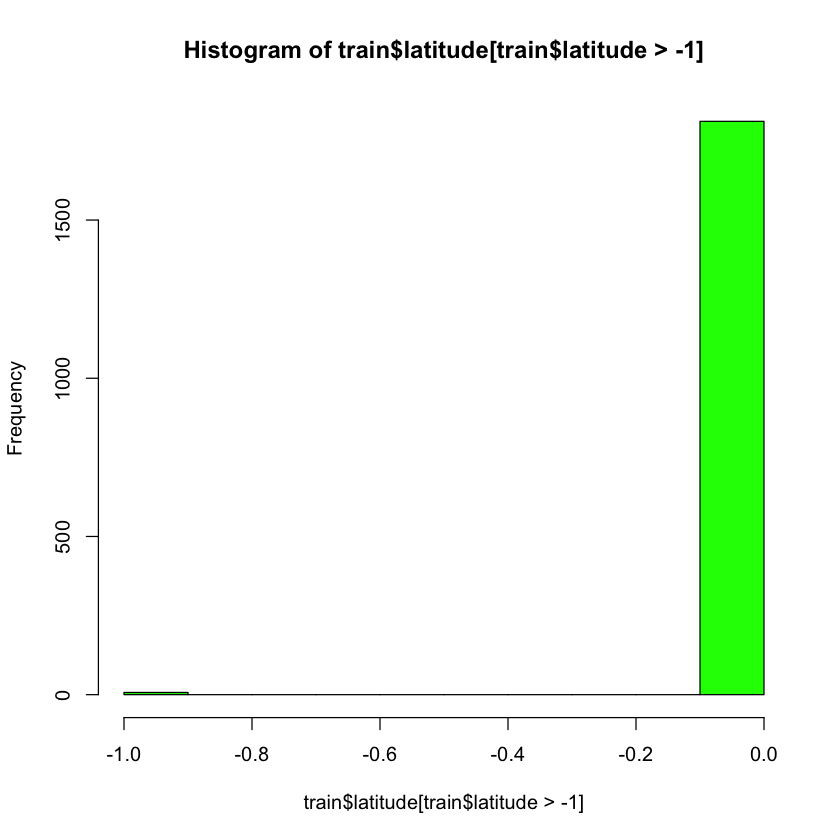

In [11]:
# LATITUDE variable (Imputation)
summary(train$latitude)
summary(test_x$latitude)
hist(train$latitude, col = "blue")
length(which(train$latitude == 0))
summary(train$latitude[train$latitude > 0])
hist(train$latitude[train$latitude > -1], col = "green")
nrow(subset(train, latitude > -1  & longitude == 0))
## Calculate the mean of latitude for each region and use those values 
## as the imputed values for the missing data of TRAINING data set
for(i in unique(train$region)) {
  if(length(train$latitude[which(train$latitude > -1 & train$region == i)]) > 0) {
    train$latitude[which(train$latitude > -1 & train$region == i)] = mean(train$latitude[which(train$region==i & train$latitude < -1)])
  }
}
## Calculate the mean of latitude for each region and use those values 
## as the imputed values for the missing data of TEST data set
for(i in unique(test_x$region)) {
  if(length(test_x$latitude[which(test_x$latitude > -1 & test_x$region == i)]) > 0) {
    test_x$latitude[which(test_x$latitude > -1 & test_x$region == i)] = mean(test_x$latitude[which(test_x$region==i & test_x$latitude < -1)])
  }
}

### gps_height

This variable represents the altitude of the pump’s location. Therefore, we can use the location details (based on latitude and longitude data) to impute missing gps_height. For this purpose, we fit a linear model for gps_height using latitude and longitude variables and then make predictions. We then impute missing gps_height values with the predicted values.

In [12]:
# GPS_HEIGHT Variable (Imputation)
## Create a subset of non-zero gps_height records
ghTrain = subset(train, gps_height != 0)
ghTest = subset(test_x, gps_height != 0)
## Create a subset of zero gps_height records
ghzTrain = subset(train, gps_height == 0)
ghzTest = subset(test_x, gps_height == 0)
## Fit a linear model for gps_height using longitude and latitude variables
lm.ghTrain = lm(gps_height ~ longitude + latitude, data = ghTrain)
summary(lm.ghTrain)
lm.ghTest = lm(gps_height ~ longitude + latitude, data = ghTest)
summary(lm.ghTest)
## Predict for zero gps_height records
pred.ghzTrain = round(predict(lm.ghTrain, newdata= ghzTrain, type = "response"))
ghzTrain$gps_height = pred.ghzTrain
pred.ghzTest = round(predict(lm.ghTest, newdata= ghzTest, type = "response"))
ghzTest$gps_height = pred.ghzTest
## Impute zero gps_height records with the predicted values
train$gps_height[train$gps_height == 0] = pred.ghzTrain
test_x$gps_height[test_x$gps_height == 0] = pred.ghzTest


Call:
lm(formula = gps_height ~ longitude + latitude, data = ghTrain)

Residuals:
     Min       1Q   Median       3Q      Max 
-1119.99  -433.93   -54.48   381.20  1588.49 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5892.4697    35.0168  168.28   <2e-16 ***
longitude   -128.5318     0.9882 -130.06   <2e-16 ***
latitude      39.7443     0.9098   43.69   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 490.8 on 38959 degrees of freedom
Multiple R-squared:  0.3581,	Adjusted R-squared:  0.358 
F-statistic: 1.087e+04 on 2 and 38959 DF,  p-value: < 2.2e-16



Call:
lm(formula = gps_height ~ longitude + latitude, data = ghTest)

Residuals:
     Min       1Q   Median       3Q      Max 
-1108.70  -442.61   -64.88   382.52  1603.44 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5888.833     70.645   83.36   <2e-16 ***
longitude   -128.676      1.993  -64.57   <2e-16 ***
latitude      39.446      1.842   21.42   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 493.7 on 9636 degrees of freedom
Multiple R-squared:  0.3564,	Adjusted R-squared:  0.3563 
F-statistic:  2669 on 2 and 9636 DF,  p-value: < 2.2e-16


### population

We impute missing (zero) population values with the median of non-zero population values. 

In [13]:
# POPULATION Variable (Imputation)
## Summary statistics for population values greater than 0
summary(train$population[train$population > 0])
summary(test_x$population[test_x$population > 0])
## Impute zero population values with the median of populatiton values greater than 0
train$population[train$population == 0] = median(train$population[train$population > 0])
test_x$population[test_x$population == 0] = median(test_x$population[test_x$population > 0])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.0    40.0   150.0   281.1   324.0 30500.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      1      40     150     291     350   11469 

### public_meeting

In [14]:
# PUBLIC_MEETING Variable
## Fill in blank public_meeting values with "unknown"
train$public_meeting[train$public_meeting == ""] = "unknown"
train$public_meeting = as.factor(train$public_meeting)
test_x$public_meeting[test_x$public_meeting == ""] = "unknown"
test_x$public_meeting = as.factor(test_x$public_meeting)

### permit

We determine whether the lack of a permit value is related to the geographical location of a pump.

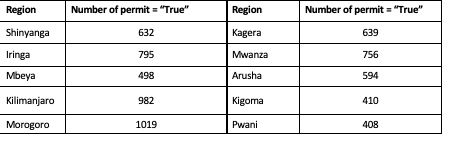
Summary statistics above shows that all region’s within the data set have at least some valid permit values. Therefore, we can impute missing permit values using region values based on the percentage of pumps within region sharing a TRUE value.

In [15]:
# PERMIT variable (Imputation)
## Explore the region variable whether it can be used to impute missing values of permit variable
### Create subset for region and permit variables
permitByregion = train[, c("id", "region", "permit")]
### Fill in missing data with "unknown"
missing_permit = unique(permitByregion$permit)
permitByregion$permit[permitByregion$permit == missing_permit[[3]]] = "unknown"
### Aggregate the data
permitByregion_true = arrange(summarise(group_by(permitByregion, region), 
                                   TotalPump= length(unique(id)),
                                   PermUnknown = sum(permit == "unknown"),
                                   PermTrue = sum(permit == "True") ), desc(TotalPump) )
### Calculate percentage of TRUE and "unknown" permit values
permitByregion_true$percentageTrue <- permitByregion_true$PermTrue /  permitByregion_true$TotalPump
permitByregion_true$percentageUnknown <- permitByregion_true$PermUnknown /  permitByregion_true$TotalPump
### Impute missing permit values based on the percentages calculated above for training dataset
persubset = subset(train, permitByregion$permit == "unknown")
for (i in 1:nrow(persubset)) {
  if (permitByregion_true$percentageTrue[permitByregion_true$region == persubset$region[i]] >= .50) {
    persubset$permit[i] = "True"
    } else {
      persubset$permit[i] = "False"
  }
}
train$permit_new = train$permit
train$permit_new[train$permit == missing_permit[[3]]] = persubset$permit
train$permit_new = as.factor(train$permit_new)
### Remove permit variable from training dataset
train = train[,!(names(train) == "permit")]

## Repeat the same process above to impute missing values of permit variable fro test dataset
### Create subset for region and permit variables
permitByregion = test_x[, c("id", "region", "permit")]
### Fill in missing data with "unknown"
missing_permit = unique(permitByregion$permit)
permitByregion$permit[permitByregion$permit == missing_permit[[2]]] = "unknown"
### Aggregate the data
permitByregion_true = arrange(summarise(group_by(permitByregion, region), 
                                        TotalPump= length(unique(id)),
                                        PermUnknown = sum(permit == "unknown"),
                                        PermTrue = sum(permit == "True") ), desc(TotalPump) )
### Calculate percentage of TRUE and "unknown" permit values
permitByregion_true$percentageTrue <- permitByregion_true$PermTrue /  permitByregion_true$TotalPump
permitByregion_true$percentageUnknown <- permitByregion_true$PermUnknown /  permitByregion_true$TotalPump
### Impute missing permit values based on the percentages calculated above for test dataset
persubset = subset(test_x, permitByregion$permit == "unknown")
for (i in 1:nrow(persubset)) {
  if (permitByregion_true$percentageTrue[permitByregion_true$region == persubset$region[i]] >= .50) {
    persubset$permit[i] = "True"
  } else {
    persubset$permit[i] = "False"
  }
}
test_x$permit_new = test_x$permit
test_x$permit_new[test_x$permit == missing_permit[[2]]] = persubset$permit
test_x$permit_new = as.factor(test_x$permit_new)
### Remove permit variable from training dataset
test_x = test_x[,!(names(test_x) == "permit")]

### Other categorical variables

In [16]:
# OTHER CATEGORICAL VARIABLES
# Convert the rest of categorical variables to factors
for (i in names(Filter(is.character, train))) {
  train[,i] = as.factor(train[,i])
}
for (i in names(Filter(is.character, test_x))) {
  test_x[,i] = as.factor(test_x[,i])
}

# Check class types of all the variables
sapply(train, class)
sapply(test_x, class)

# List all the independent variables available for predictive modeling
names(train[,3:ncol(train)])

id          status_group            amount_tsh 
            "integer"              "factor"             "numeric" 
           gps_height             longitude              latitude 
            "numeric"             "numeric"             "numeric" 
                basin                region            population 
             "factor"              "factor"             "integer" 
       public_meeting     construction_year extraction_type_group 
             "factor"             "integer"              "factor" 
           management               payment         water_quality 
             "factor"              "factor"              "factor" 
             quantity                source          source_class 
             "factor"              "factor"              "factor" 
      waterpoint_type             install_3            permit_new 
             "factor"              "factor"              "factor"

id            amount_tsh            gps_height 
            "integer"             "numeric"             "numeric" 
            longitude              latitude                 basin 
            "numeric"             "numeric"              "factor" 
               region            population        public_meeting 
             "factor"             "integer"              "factor" 
    construction_year extraction_type_group            management 
            "integer"              "factor"              "factor" 
              payment         water_quality              quantity 
             "factor"              "factor"              "factor" 
               source          source_class       waterpoint_type 
             "factor"              "factor"              "factor" 
            install_3            permit_new 
             "factor"              "factor"

[1] "amount_tsh"            "gps_height"            "longitude"            
 [4] "latitude"              "basin"                 "region"               
 [7] "population"            "public_meeting"        "construction_year"    
[10] "extraction_type_group" "management"            "payment"              
[13] "water_quality"         "quantity"              "source"               
[16] "source_class"          "waterpoint_type"       "install_3"            
[19] "permit_new"

## Model Development

### Bagging

Bagging model was constructed using all independent variables with a total of 5 trees. We observe that all the other variables are significant and add value to our model. Number of bootstrap replications is 15. Number of variables randomly sampled as candidates at each split is 19 since in bagging we should use all of the independent variables while constructing the model.

The bagging model is constructed as follows:

```R
model_bag = bagging(status_group ~ . -id, data = train, importance = TRUE, coob = TRUE, nbagg = 15, ntree = 200, mtry = 19)
```

With using this model, we conclude that our train accuracy is 0.9619 (96%). Also, our model yields 0.8001 (80%) test accuracy. Besides, Out-of-bag estimate of misclassification error is 0.225.

![image-2.png](attachment:image-2.png)

In [17]:
# Fit a model
set.seed(1234)
model_bag = bagging(as.factor(status_group) ~ . -id,
                         data = train, importance = TRUE, coob = TRUE, nbagg = 15, ntree = 200, mtry = 19)
# Make predictions for TRAINING data
predTrain_bag = predict(model_bag, train)
# Compute TRAINING Accuracy
cmTrain_bag = confusionMatrix(predTrain_bag, train$status_group)
cmTrain_bag$overall[1] 
# Make predictions for TEST data 
predTest_bag = predict(model_bag, test_x)
# Create submission data frame for Random Forest technique
submission = data.frame(test_x$id)
submission$status_group = predTest_bag
names(submission)[1] = "id"
write.csv(submission, file = "Submission_Bagging.csv", row.names = FALSE)

Accuracy 
0.9906061

### Random Forest

The random forest model was constructed using all the variables with a total of 500 trees and 2 as the node size. After the first fitting, we used random forest variable importance measures to understand whether the predictors used in the model are significantly important. Based on the mean decrease accuracy and mean decrease gini, we dropped a feature and fit the model again without that feature. We repeated this process until we got the highest training accuracy possible. source_class, water_quality, and amount_tsh features have been dropped in this process. 

The final model constructed is as follows:

```R
model_rf = randomForest(status_group ~ . -id -source_class -water_quality -amount_tsh, data = train, importance = TRUE, ntree = 500, nodesize = 2)
```

Using the model above, we computed the training and test accuracies. The model yielded a training accuracy of 0.9541 (95%) and a test accuracy of 0.8179 (82%), which is the highest test accuracy among five techniques used.

![image-7.png](attachment:image-7.png)

Accuracy 
0.9527609

,functional,functional needs repair,non functional,MeanDecreaseAccuracy,MeanDecreaseGini
gps_height,119.66907,58.16395,86.25992,150.07743,2903.6549
longitude,113.08495,71.65656,92.94105,139.44372,3440.2728
latitude,120.37707,68.75731,85.23250,153.41061,3371.9314
basin,58.27089,54.77126,64.18443,69.56133,724.3248
region,94.84387,80.33214,94.83661,114.85677,1206.3045
population,70.99473,28.47486,88.07179,94.33185,1442.9870
public_meeting,49.52610,35.55545,43.48082,59.07562,313.1643
construction_year,79.16134,57.66503,77.25506,87.92254,1687.1202
extraction_type_group,122.52772,70.90791,80.53893,127.37350,2090.2311
management,67.06330,28.86111,62.03189,72.40995,832.6080


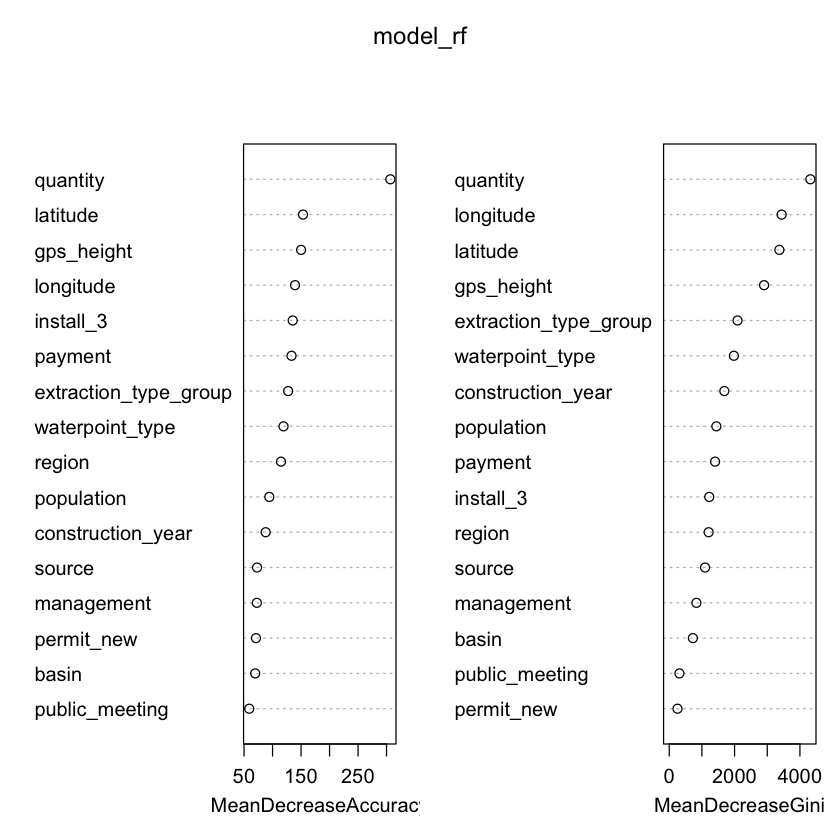

In [18]:
# Fit a model
set.seed(1234)
model_rf = randomForest(as.factor(status_group) ~ . -id -source_class -water_quality -amount_tsh,
                        data = train, importance = TRUE, ntree = 500, nodesize = 2)
# Make predictions for TRAINING data 
predTrain_rf = predict(model_rf, train)
# Compute TRAINING Accuracy
cmTrain_rf = confusionMatrix(predTrain_rf, train$status_group)
cmTrain_rf$overall[1]
# Check how important the inputs are to the model
importance(model_rf)
varImpPlot(model_rf)
# Make predictions for TEST data 
predTest_rf = predict(model_rf, test_x)
# Create submission data frame for Random Forest technique
submission = data.frame(test_x$id)
submission$status_group = predTest_rf
names(submission)[1] = "id"
write.csv(submission, file = "Submission_RandomForest.csv", row.names = FALSE)

### Boosting

Boosting was applied using 10-fold cross validation with a tree size of 150 and a shrinkage of 0.2. We fitted all the variables to the model since it gave us a lower train and test error than the models we have tried.

So, the model is as follows;

```R
model_boost = train(status_group ~  ., data = train, 
method = "gbm", trControl = fitControl, verbose = TRUE, tuneGrid = gbmGrid)
```

This model has a training accuracy of 0.7571 (76%) and a test accuracy of 0.7587 (76%). Therefore, boosting performs the worst in terms of test accuracy.

![image-12.png](attachment:image-12.png)

In [19]:
# Perform 10-fold cross-validation
set.seed(1234)
fitControl = trainControl(
  method = "repeatedcv",
  number = 5,
  #classProbs = TRUE,
  ## repeated one times
  repeats = 3)
gbmGrid = expand.grid(interaction.depth = 2,
                        n.trees = 150,
                        shrinkage = 0.2,
                        n.minobsinnode = 10)
# Fit a model
set.seed(1234)
model_boost = train(as.factor(status_group) ~ . -id, data = train,
                    method = "gbm",
                    trControl = fitControl,
                    verbose = TRUE,
                    tuneGrid = gbmGrid)
# Make predictions for TRAINING data 
predTrain_boost = predict(model_boost, newdata = train, n.trees = 150)
# Compute TRAINING Accuracy
cmTrain_boost = confusionMatrix(predTrain_boost, train$status_group)
cmTrain_boost$overall[1]
# Make predictions for TEST data 
predTest_boost = predict(model_boost, newdata = test_x, n.trees = 150)
# Create submission data frame for Boosting technique
submission = data.frame(test_x$id)
submission$status_group = predTest_boost
names(submission)[1] = "id"
write.csv(submission, file = "Submission_Boosting.csv", row.names = FALSE)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.0986             nan     0.2000    0.2135
     2        0.9578             nan     0.2000    0.1118
     3        0.8854             nan     0.2000    0.0662
     4        0.8436             nan     0.2000    0.0418
     5        0.8163             nan     0.2000    0.0374
     6        0.7906             nan     0.2000    0.0202
     7        0.7761             nan     0.2000    0.0174
     8        0.7638             nan     0.2000    0.0125
     9        0.7550             nan     0.2000    0.0105
    10        0.7475             nan     0.2000    0.0138
    20        0.6968             nan     0.2000    0.0024
    40        0.6584             nan     0.2000    0.0011
    60        0.6385             nan     0.2000   -0.0000
    80        0.6260             nan     0.2000    0.0005
   100        0.6156             nan     0.2000   -0.0001
   120        0.6071             nan     0.2000    0.0001
   140        

Accuracy 
0.7571549

### SVM with OVA

A SVM model was constructed using all the variables with a radius kernel and one-versus-all classification. Before fitting a SVM model, we performed cross-validation to select the best choice of gamma and cost for a SVM with a radial kernel and one-versus-all classification. Since the data has too many observation, the cross-validation could be performed only using 2000 observations from the training dataset.
			
![image-15.png](attachment:image-15.png)

According to the results by using `tune()`, the best choice of gamma and cost are 0.5 and 1, respectively.

Using these parameters, the final model constructed is as follows:

```R
model_svm.ova = svm(status_group ~ . -id, data = train, kernel = "radial", cost = 1, gamma = 0.5, class.type = "one.versus.all", verbosity = 0)
```

The fitted yielded a training accuracy of 0.8470 (85%) and a test accuracy of 0.7923 (79%).

![image-20.png](attachment:image-20.png)

In [20]:
# Perform cross-validation to select the best choice of gamma and cost parameters for a SVM with a radial kernel
set.seed(1234)
tuneout_svm.ova = tune(svm, as.factor(status_group) ~ . -id, data = train[1:2000,], kernel = "radial", ranges = list(cost = c(0.1, 1, 10, 100), gamma = c(0.5, 1, 4)), class.type = "one.versus.all")
summary(tuneout_svm.ova)
# Fit a model
set.seed(1234)
model_svm.ova = svm(as.factor(status_group) ~ . -id, data = train, kernel = "radial", cost = 1, gamma = 0.5, class.type = "one.versus.all", verbosity = 0)
# Make predictions for TRAINING data 
predTrain_svm.ova = predict(model_svm.ova, train)
# Compute TRAINING Accuracy
cmTrain_svm.ova = confusionMatrix(predTrain_svm.ova, train$status_group)
cmTrain_svm.ova$overall[1]
# Make predictions for TEST data 
predTest_svm.ova = predict(model_svm.ova, test_x)
# Create submission data frame for SVM with OVA technique
submission = data.frame(test_x$id)
submission$status_group = predTest_svm.ova
names(submission)[1] = "id"
write.csv(submission, file = "Submission_SVM-OVA.csv", row.names = FALSE)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.326 

- Detailed performance results:
    cost gamma  error dispersion
1    0.1   0.5 0.4565 0.03091655
2    1.0   0.5 0.3260 0.02131770
3   10.0   0.5 0.3280 0.02201010
4  100.0   0.5 0.3380 0.02740641
5    0.1   1.0 0.4535 0.03223611
6    1.0   1.0 0.3855 0.04192917
7   10.0   1.0 0.3710 0.03526093
8  100.0   1.0 0.3710 0.03588562
9    0.1   4.0 0.4535 0.03223611
10   1.0   4.0 0.4130 0.03910101
11  10.0   4.0 0.4160 0.03717825
12 100.0   4.0 0.4155 0.03847438


Accuracy 
0.8470034

### SVM with OVO

A SVM model was constructed using all the variables with a radius kernel. Before fitting a SVM model, we performed cross-validation to select the best choice of gamma and cost for a SVM with a radial kernel and one-versus-one classification. Since the data has too many observation, the cross-validation could be performed only using 2000 observations from the training dataset.
			
![image-15.png](attachment:image-15.png)

According to the results by using `tune(`), the best choice of gamma and cost are 0.5 and 1, respectively.

Using these parameters, the final model constructed is as follows:

```R
model_svm.ovo = svm(status_group ~ . -id, data = train, kernel = "radial", cost = 1, gamma = 0.5, class.type = "one.versus.one", verbosity = 0)
```

The fitted yielded a training accuracy of 0.8470 (85%) and a test accuracy of 0.7923 (79%).

![image-24.png](attachment:image-24.png)

In [21]:
# Perform cross-validation to select the best choice of gamma and cost parameters for a SVM with a radial kernel
set.seed(1234)
tuneout_svm.ovo = tune(svm, as.factor(status_group) ~ . -id, data = train[1:2000,], kernel = "radial", ranges = list(cost = c(0.1, 1, 10, 100), gamma = c(0.5, 1, 4)))
summary(tuneout_svm.ovo)
# Fit a model
set.seed(1234)
model_svm.ovo = svm(as.factor(status_group) ~ . -id, data = train, kernel = "radial", cost = 1, gamma = 0.5, class.type = "one.versus.one", verbosity = 0)
# Make predictions for TRAINING data 
predTrain_svm.ovo = predict(model_svm.ovo, train)
# Compute TRAINING Accuracy
cmTrain_svm.ovo = confusionMatrix(predTrain_svm.ovo, train$status_group)
cmTrain_svm.ovo$overall[1]
# Make predictions for TEST data 
predTest_svm.ovo = predict(model_svm.ovo, test_x)
# Create submission data frame for SVM with OVO technique
submission = data.frame(test_x$id)
submission$status_group = predTest_svm.ovo
names(submission)[1] = "id"
write.csv(submission, file = "Submission_SVM-OVO.csv", row.names = FALSE)


Parameter tuning of ‘svm’:

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
    1   0.5

- best performance: 0.326 

- Detailed performance results:
    cost gamma  error dispersion
1    0.1   0.5 0.4565 0.03091655
2    1.0   0.5 0.3260 0.02131770
3   10.0   0.5 0.3280 0.02201010
4  100.0   0.5 0.3380 0.02740641
5    0.1   1.0 0.4535 0.03223611
6    1.0   1.0 0.3855 0.04192917
7   10.0   1.0 0.3710 0.03526093
8  100.0   1.0 0.3710 0.03588562
9    0.1   4.0 0.4535 0.03223611
10   1.0   4.0 0.4130 0.03910101
11  10.0   4.0 0.4160 0.03717825
12 100.0   4.0 0.4155 0.03847438


Accuracy 
0.8470034

## Results

Train accuracy and test accuracy for each of the five techniques are provided in the following table.

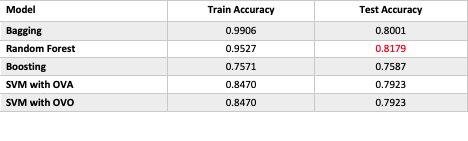
When we look at the above table, we see that bagging has the highest training accuracy while random forest has the highest test accuracy. Therefore, we can easily conclude that bagging overfits the training data. The model with the worst performance in both training and test data is boosting. SVM with OVA and OVO exactly gave the same results and they perform better than boosting when it comes to test data. All things considered, we choose random forest since this method has the best test accuracy performance among five techniques used.